# Demo SingleRun
This notebook shows a single run consisting of the following four phases:
* sail empty
* loading
* sail full
* unloading

In [1]:
import datetime, time
import simpy

import shapely.geometry


import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)


## Definition of Site

In [3]:
from_site = Site(
    env=my_env,
    name="Winlocatie",
    geometry=location_from_site,
    capacity=100,
    level=50,
)


to_site = Site(
    env=my_env,
    name="Dumplocatie",
    geometry=location_to_site,
    capacity=50,
    level=0,
)

## Definition of Vessels

In [4]:
hopper = TransportProcessingResource(
    env=my_env,
    name="Hopper 01",
    geometry=location_from_site,
    loading_rate=0.00001,
    unloading_rate=0.00001,
    capacity=4,
    compute_v=lambda x: 10,
)

## Defenition of the activities

In [5]:
single_run = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=hopper,
        destination=from_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="Transfer MP",
        registry=registry,
        processor=hopper,
        origin=from_site,
        destination=hopper,
        amount=4,
        duration=1000,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing filler",
        registry=registry,
        mover=hopper,
        destination=to_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="Transfer TP",
        registry=registry,
        processor=hopper,
        origin=hopper,
        destination=to_site,
        amount=4,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="Basic activity",
        registry=registry,
        duration=0,
        additional_logs=[hopper],
    ),
]


activity = model.SequentialActivity(
    env=my_env,
    name="Single run process",
    registry=registry,
    sub_processes=single_run,
)


while_activity = model.WhileActivity(
    env=my_env,
    name="while",
    registry=registry,
    sub_processes=[activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

In [6]:
model.register_processes([while_activity])
my_env.run()

In [7]:
plot.get_log_dataframe(hopper, [while_activity, *single_run, activity])

,Activity,Timestamp,ActivityState,geometry,container level,type,ref
0,sailing empty,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
1,sailing empty,1970-01-01 00:00:00.000000,STOP,POINT (4.18055556 52.18664444),0.0,NaN,NaN
2,Transfer MP,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
3,Transfer MP,1970-01-01 00:16:40.000000,STOP,POINT (4.18055556 52.18664444),4.0,NaN,NaN
4,sailing filler,1970-01-01 00:16:40.000000,START,POINT (4.18055556 52.18664444),4.0,NaN,NaN
...,...,...,...,...,...,...,...
125,sailing filler,1970-01-01 13:29:30.614782,STOP,POINT (4.25222222 52.11428333),2.0,NaN,NaN
126,Transfer TP,1970-01-01 13:29:30.614782,START,POINT (4.25222222 52.11428333),2.0,NaN,NaN
127,Transfer TP,1970-01-01 13:46:10.614782,STOP,POINT (4.25222222 52.11428333),0.0,NaN,NaN
128,Basic activity,1970-01-01 13:46:10.614782,START,POINT (4.25222222 52.11428333),0.0,additional log,911fe2dc-8aee-48f9-ab5f-de31d538f7cd


In [8]:
 plot.vessel_planning([hopper, from_site, to_site])

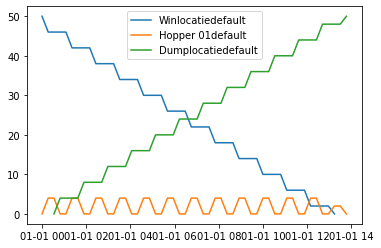

In [9]:
fig = plot.get_step_chart([from_site, hopper, to_site])

In [11]:
{ID:next(a for a in model.helpers.get_subprocesses(while_activity) if a.id == ID) for ID in list(set(hopper.log["ActivityID"]))}

{'119680d3-6565-4d0f-9fb1-6a87e5ed3583': <openclsim.model.move_activity.MoveActivity at 0x7f21bf6432b0>,
 '911fe2dc-8aee-48f9-ab5f-de31d538f7cd': <openclsim.model.basic_activity.BasicActivity at 0x7f21bf643390>,
 '6af900fe-9dd7-4b05-aa62-3cd808d2f246': <openclsim.model.move_activity.MoveActivity at 0x7f21bf6431d0>,
 'fd7e83ce-7319-4adf-a7c6-a09149cbe3b7': <openclsim.model.shift_amount_activity.ShiftAmountActivity at 0x7f21bf643208>,
 '11613caf-3dbb-4d09-a471-1dc0250a2776': <openclsim.model.shift_amount_activity.ShiftAmountActivity at 0x7f21bf643320>}